# Patient Similarity Network GNN Proof of Concept

A. Lundervold w/ Claude 3.5 Sonnet , 2025-01-07   (using Google Colab)

2025-01-08: `bmed365-cuda` conda environment for accessing GPU

```bash
conda env create -f environment-cuda.yml
activate bmed365-cuda
conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
```

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/BMED365-2025/blob/main/Lab2-DL/notebooks/05-psn-graph-neural-networks.ipynb)

I'll help you explore Patient Similarity Networks (PSNs) and Graph Neural Networks (GNNs) in the context of healthcare analytics. Let me break this down systematically:

1. Patient Similarity Networks:
- PSNs are mathematical representations where each node represents a patient
- Edges between nodes indicate similarity between patients based on various medical features
- These features typically include:
  - Demographics (age, gender, ethnicity)
  - Clinical measurements (lab results, vital signs)
  - Diagnoses and procedures (ICD codes)
  - Medications
  - Genetic information when available

2. Creating Patient Similarity:
- Distance/similarity metrics are used to quantify patient relationships
- Common approaches include:
  - Euclidean distance for continuous variables
  - Jaccard similarity for categorical variables
  - Custom hybrid metrics for mixed data types
- Feature weighting is often applied to prioritize more relevant characteristics
- Dimensionality reduction techniques may be used to handle high-dimensional patient data

3. GNNs for Patient Networks:
- GNNs are particularly well-suited for analyzing PSNs because they can:
  - Learn from both node features and network structure
  - Aggregate information from similar patients
  - Generate embeddings that capture complex patient relationships
- Common GNN architectures for healthcare:
  - GraphSAGE for handling large-scale patient networks
  - GAT (Graph Attention Networks) for learning which patient similarities are most important
  - GCN (Graph Convolutional Networks) for basic feature aggregation

4. Applications:
- Disease prediction and risk stratification
- Treatment recommendation based on similar patients' outcomes
- Patient subgroup discovery
- Personalized medicine approaches
- Clinical trial matching

5. Technical Implementation Considerations:
- Handling missing data
- Dealing with temporal aspects of patient data
- Ensuring privacy and security
- Scalability for large patient populations
- Interpretability requirements for clinical use

Would you like me to dive deeper into any of these aspects? I can also provide code examples for implementing PSNs or GNNs for specific healthcare applications.

_Can you make a prototype PoC in python?_

I'll create a proof of concept that demonstrates building a Patient Similarity Network and applying a simple GNN for patient outcome prediction. I'll use PyTorch Geometric for the GNN implementation.



This PoC demonstrates several key concepts:

1. Patient Similarity Network Creation:
- Features are preprocessed and standardized
- Cosine similarity is used to measure patient similarity
- A threshold is applied to create the adjacency matrix

2. GNN Architecture:
- Uses 3 Graph Convolutional layers
- Includes dropout for regularization
- Binary classification output (could predict patient outcomes, readmission risk, etc.)

3. Training Pipeline:
- Synthetic data generation for demonstration
- Model training with binary cross-entropy loss
- Basic evaluation metrics

To extend this PoC for real-world use, you would want to:

1. Enhance feature processing:
- Add proper categorical variable encoding
- Implement more sophisticated missing value handling
- Add feature selection/importance analysis

2. Improve the network structure:
- Implement multiple similarity metrics
- Add edge weights based on similarity scores
- Consider temporal aspects of patient data

3. Expand the model:
- Add attention mechanisms
- Implement more sophisticated architectures (GraphSAGE, GAT)
- Add interpretability components


I'll enhance the model with a Graph Attention Network (GAT) layer and add interpretability components to help understand the model's decisions.

I'll enhance the model with a Graph Attention Network (GAT) layer and add interpretability components to help understand the model's decisions.



Key enhancements in this version:

1. Attention Mechanisms:
- Replaced GCN with GATv2Conv (improved version of GAT)
- Added multi-head attention (4 heads per layer)
- Stores attention weights for interpretation
- Feature-level attention through the feature_attention layer

2. Interpretability Components:
- ModelInterpreter class for explaining predictions
- Feature importance visualization
- Neighbor attention weight visualization
- Training monitoring with loss and accuracy tracking

3. Enhanced Network Structure:
- Weighted adjacency matrix based on similarity scores
- Better feature preprocessing
- Meaningful feature names for interpretability

4. Model Architecture:
- Three GAT layers with skip connections
- Dropout and ELU activation functions
- Feature importance layer

5. Visualization:
- Feature importance bar plots
- Attention weight heatmaps
- Training progress monitoring

To use this enhanced version:

```python
# Train model and get interpreter
model, interpreter, training_stats = main()

# Explain prediction for a specific patient
patient_idx = 0
explanation = interpreter.explain_prediction(patient_idx)

# Visualize explanation
interpreter.visualize_explanation(patient_idx)
```

Would you like me to:
1. Add more sophisticated visualization options?
2. Implement additional interpretability metrics?
3. Add support for temporal patient data?
4. Enhance the attention mechanism further?

I'll enhance the code with temporal support, advanced visualizations, and additional interpretability metrics.



Key enhancements in this version:

1. Temporal Data Support:
- Added `TemporalPatientFeatures` class for processing time series data
- Implemented Dynamic Time Warping for temporal similarity
- Added temporal attention mechanism
- Created synthetic temporal data generator with trends and seasonality

2. Advanced Visualizations:
- Time series patterns visualization
- Network structure visualization using NetworkX
- UMAP embeddings for patient clustering
- Community structure analysis
- Feature correlation heatmaps
- Degree distribution plots

3. Enhanced Interpretability:
- SHAP values for feature importance
- Feature interaction analysis
- Temporal pattern analysis
- Community detection
- Network topology metrics
- Correlation analysis

4. Additional Metrics:
- Node centrality measures
- Community detection
- Feature interaction strengths
- Temporal pattern similarity

To use the enhanced features:

```python
# Train model and get interpreter
model, interpreter, temporal_df = main()

# Generate visualizations for a patient
patient_idx = 0
temporal_viz = interpreter.visualize_temporal_patterns(
    patient_idx,
    temporal_df[temporal_df['patient_id'] == patient_idx].set_index('timestamp')
)

# Visualize network structure
network_viz = interpreter.visualize_network_structure()

# Get SHAP values for interpretation
shap_values = interpreter.compute_shap_values(patient_idx)

# Analyze feature interactions
interactions = interpreter.compute_feature_interactions(patient_idx)
```

Would you like me to:
1. Add more advanced temporal patterns analysis (e.g., change point detection, trend analysis)?
2. Implement additional network metrics or community detection algorithms?
3. Add support for handling missing temporal data?
4. Enhance the visualization options further with interactive plots?

In [6]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    !pip install torch_geometric
    !pip install umap
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [7]:
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GATv2Conv, GlobalAttention
from torch_geometric.data import Data, Batch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import networkx as nx
from scipy.stats import spearmanr
import umap
import shap

In [8]:
print("torch:", torch.__version__)
print("torch_geometric:", torch_geometric.__version__)
print("shap:", shap.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))
print("torch.cuda.get_device_properties(0):", torch.cuda.get_device_properties(0))
    

torch: 2.5.1
torch_geometric: 2.6.1
shap: 0.46.0
torch.cuda.is_available(): True
torch.cuda.get_device_name(0): NVIDIA RTX A5000 Laptop GPU
torch.cuda.get_device_properties(0): _CudaDeviceProperties(name='NVIDIA RTX A5000 Laptop GPU', major=8, minor=6, total_memory=16116MB, multi_processor_count=48, uuid=f78ec681-cecf-19d1-6cf7-0ac2e2802823, L2_cache_size=4MB)


In [10]:
class TemporalPatientFeatures:
    def __init__(self, max_sequence_length=10):
        self.max_sequence_length = max_sequence_length
        self.numerical_scaler = StandardScaler()
        self.temporal_scaler = MinMaxScaler()
        
    def process_temporal_data(self, temporal_df):
        """
        Process temporal patient data with variable sequence lengths
        """
        # Drop non-feature columns for sequence creation
        feature_cols = [col for col in temporal_df.columns 
                       if col not in ['patient_id', 'timestamp']]
        
        # Group by patient and sort by timestamp
        grouped = temporal_df.groupby('patient_id', as_index=False)
        
        # Pad or truncate sequences
        padded_sequences = []
        for _, patient_data in grouped:
            # Sort by timestamp and select features
            sequence = (patient_data.sort_values('timestamp')
                      [feature_cols]
                      .values[:self.max_sequence_length])
            
            # Pad if necessary
            if len(sequence) < self.max_sequence_length:
                padding = np.zeros((self.max_sequence_length - len(sequence), 
                                  len(feature_cols)))
                sequence = np.vstack([sequence, padding])
            
            padded_sequences.append(sequence)
            
        return np.array(padded_sequences)

class TemporalPatientSimilarityNetwork:
    def __init__(self, similarity_threshold=0.7):
        self.similarity_threshold = similarity_threshold
        self.feature_processor = TemporalPatientFeatures()
        
    def compute_temporal_similarity(self, seq1, seq2):
        """
        Compute similarity between two temporal sequences
        """
        # Dynamic Time Warping distance
        dtw_distance = self._dtw_distance(seq1, seq2)
        # Normalize to similarity score
        similarity = 1 / (1 + dtw_distance)
        return similarity
    
    def _dtw_distance(self, seq1, seq2):
        """
        Compute Dynamic Time Warping distance between sequences
        """
        n, m = len(seq1), len(seq2)
        dtw_matrix = np.inf * np.ones((n + 1, m + 1))
        dtw_matrix[0, 0] = 0
        
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = np.linalg.norm(seq1[i-1] - seq2[j-1])
                dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                            dtw_matrix[i, j-1],
                                            dtw_matrix[i-1, j-1])
        
        return dtw_matrix[n, m]

class TemporalGAT(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=32, num_heads=4):
        super(TemporalGAT, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        
        # Initial feature transformation
        self.feature_transform = torch.nn.Linear(num_features, hidden_dim)
        
        # GAT layers
        self.gat_layers = torch.nn.ModuleList([
            GATv2Conv(hidden_dim, hidden_dim, heads=num_heads, dropout=0.2),
            GATv2Conv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=0.2),
            GATv2Conv(hidden_dim * num_heads, hidden_dim, heads=1, concat=False)
        ])
        
        # Feature attention
        self.feature_attention = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
        
        # Output layer
        self.output_layer = torch.nn.Linear(hidden_dim, 1)
        
    def forward(self, x, edge_index, batch=None):
        # Store attention weights
        self.attention_weights = []
        
        # Initial feature transformation
        x = self.feature_transform(x)
        
        # Apply GAT layers
        for layer in self.gat_layers[:-1]:
            x, attention = layer(x, edge_index, return_attention_weights=True)
            self.attention_weights.append(attention)
            x = F.elu(x)
            x = F.dropout(x, p=0.2, training=self.training)
        
        # Final GAT layer
        x, attention = self.gat_layers[-1](x, edge_index, return_attention_weights=True)
        self.attention_weights.append(attention)
        
        # Feature attention
        feature_weights = torch.sigmoid(self.feature_attention(x))
        x = x * feature_weights
        
        # Output transformation
        x = self.output_layer(x)
        
        return torch.sigmoid(x), feature_weights

class AdvancedModelInterpreter:
    def __init__(self, model, data, feature_names):
        self.model = model
        self.data = data
        self.feature_names = feature_names
        
    def compute_shap_values(self, patient_idx):
        """
        Compute SHAP values for feature importance
        """
        # Create background data for SHAP
        background_data = self.data.x[:100]  # Use first 100 samples as background
        
        def model_predict(x):
            with torch.no_grad():
                pred, _ = self.model(torch.tensor(x, dtype=torch.float), self.data.edge_index)
            return pred.numpy()
        
        explainer = shap.KernelExplainer(model_predict, background_data.numpy())
        shap_values = explainer.shap_values(self.data.x[patient_idx:patient_idx+1].numpy())
        return shap_values[0] if isinstance(shap_values, list) else shap_values
    
    def compute_feature_interactions(self, patient_idx):
        """
        Compute feature interaction strengths
        """
        features = self.data.x[patient_idx].detach().numpy()
        correlations = np.corrcoef(features.reshape(-1, 1).T)
        return np.abs(correlations)
    
    def visualize_temporal_patterns(self, patient_idx, temporal_data):
        """
        Visualize temporal patterns for a patient
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Time series plot
        for col in temporal_data.columns:
            axes[0, 0].plot(temporal_data.index, temporal_data[col], label=col)
        axes[0, 0].set_title('Temporal Feature Patterns')
        axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Feature correlation heatmap
        sns.heatmap(temporal_data.corr(), ax=axes[0, 1], cmap='coolwarm')
        axes[0, 1].set_title('Feature Correlations Over Time')
        
        # Model prediction confidence
        with torch.no_grad():
            pred, attention = self.model(self.data.x[patient_idx:patient_idx+1], 
                                      self.data.edge_index)
        attention = attention.detach().numpy()
        
        # Feature importance plot
        importance = attention.mean(axis=0)
        features_sorted = sorted(zip(self.feature_names, importance), 
                               key=lambda x: x[1], reverse=True)
        feat_names, feat_imp = zip(*features_sorted)
        
        axes[1, 0].barh(range(len(feat_imp)), feat_imp)
        axes[1, 0].set_yticks(range(len(feat_names)))
        axes[1, 0].set_yticklabels(feat_names)
        axes[1, 0].set_title('Feature Importance')
        
        # Network neighborhood
        edge_weights = []
        neighbor_indices = []
        for i, (src, dst) in enumerate(self.data.edge_index.T):
            if src == patient_idx:
                neighbor_indices.append(dst.item())
                edge_weights.append(attention[i])
        
        if neighbor_indices:
            axes[1, 1].bar(range(len(neighbor_indices)), edge_weights)
            axes[1, 1].set_title('Neighbor Attention Weights')
            axes[1, 1].set_xlabel('Neighbor Index')
            axes[1, 1].set_ylabel('Attention Weight')
        else:
            axes[1, 1].text(0.5, 0.5, 'No neighbors found', 
                          horizontalalignment='center',
                          verticalalignment='center')
            axes[1, 1].set_title('Network Neighborhood')
        
        plt.tight_layout()
        return fig
    
    def visualize_network_structure(self):
        """
        Visualize the patient similarity network structure
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Convert to networkx graph
        edge_index = self.data.edge_index.numpy()
        G = nx.Graph()
        for i in range(edge_index.shape[1]):
            G.add_edge(edge_index[0, i], edge_index[1, i])
        
        # Network structure plot
        pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()))
        nx.draw(G, pos, ax=axes[0, 0], node_size=100, 
               node_color='lightblue', alpha=0.6)
        axes[0, 0].set_title('Patient Similarity Network')
        
        # Degree distribution
        degrees = [d for n, d in G.degree()]
        axes[0, 1].hist(degrees, bins=20)
        axes[0, 1].set_title('Node Degree Distribution')
        axes[0, 1].set_xlabel('Degree')
        axes[0, 1].set_ylabel('Count')
        
        # Model predictions distribution
        with torch.no_grad():
            preds, _ = self.model(self.data.x, self.data.edge_index)
        preds = preds.numpy().flatten()
        
        axes[1, 0].hist(preds, bins=20)
        axes[1, 0].set_title('Prediction Distribution')
        axes[1, 0].set_xlabel('Prediction Value')
        axes[1, 0].set_ylabel('Count')
        
        # Global feature importance
        with torch.no_grad():
            _, attention = self.model(self.data.x, self.data.edge_index)
        importance = attention.mean(axis=0).detach().numpy()
        
        features_sorted = sorted(zip(self.feature_names, importance), 
                               key=lambda x: x[1], reverse=True)
        feat_names, feat_imp = zip(*features_sorted)
        
        axes[1, 1].barh(range(len(feat_imp)), feat_imp)
        axes[1, 1].set_yticks(range(len(feat_names)))
        axes[1, 1].set_yticklabels(feat_names)
        axes[1, 1].set_title('Global Feature Importance')
        
        plt.tight_layout()
        return fig

def create_synthetic_temporal_data(num_patients=100, num_features=10, 
                                 sequence_length=10):
    """
    Create synthetic temporal patient data with realistic patterns
    """
    # Create feature names
    feature_names = [
        'age', 'bmi', 'blood_pressure', 'glucose',
        'heart_rate', 'cholesterol', 'hemoglobin',
        'white_blood_cells', 'platelets', 'creatinine'
    ][:num_features]
    
    # Generate base date range
    base_date = datetime(2024, 1, 1)
    date_range = [base_date + timedelta(days=i) for i in range(sequence_length)]
    
    # Create empty list to store all records
    all_records = []
    
    for patient_id in range(num_patients):
        # Generate patient-specific baseline values
        baseline = np.random.randn(num_features)
        
        # Generate time series with trend and seasonality
        time = np.linspace(0, 2*np.pi, sequence_length)
        trend = np.linspace(0, 0.5, sequence_length)  # Reduced trend magnitude
        seasonal = 0.2 * np.sin(time)  # Reduced seasonality magnitude
        
        for t in range(sequence_length):
            # Generate features with baseline, trend, and seasonality
            features = baseline + trend[t] + seasonal[t] + 0.1 * np.random.randn(num_features)
            
            # Create record
            record = {
                'patient_id': patient_id,
                'timestamp': date_range[t]
            }
            
            # Add features
            for feat_idx, feat_name in enumerate(feature_names):
                record[feat_name] = features[feat_idx]
            
            all_records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(all_records)
    
    return df

def main():
    # Generate synthetic temporal data
    temporal_df = create_synthetic_temporal_data()
    
    # Process temporal data
    feature_processor = TemporalPatientFeatures()
    temporal_sequences = feature_processor.process_temporal_data(temporal_df)
    
    # Build similarity network
    network = TemporalPatientSimilarityNetwork()
    similarity_matrix = np.zeros((len(temporal_sequences), len(temporal_sequences)))
    
    for i in range(len(temporal_sequences)):
        for j in range(i+1, len(temporal_sequences)):
            sim = network.compute_temporal_similarity(
                temporal_sequences[i],
                temporal_sequences[j]
            )
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim
    
    # Create PyTorch Geometric data
    edge_index = torch.tensor(np.where(similarity_matrix > network.similarity_threshold),
                            dtype=torch.long)
    x = torch.tensor(temporal_sequences[:, -1, :], dtype=torch.float)
    y = torch.tensor(np.random.binomial(1, 0.3, len(temporal_sequences)),
                    dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Initialize model and optimizer
    model = TemporalGAT(num_features=temporal_sequences.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Train model
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out, _ = model(data.x, data.edge_index)
        loss = F.binary_cross_entropy(out.flatten(), data.y)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            pred = (out.flatten() > 0.5).float()
            acc = (pred == data.y).float().mean()
            print(f'Epoch {epoch+1}/100, Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}')
    
    # Initialize interpreter
    interpreter = AdvancedModelInterpreter(
        model,
        data,
        feature_names=temporal_df.columns[2:].tolist()
    )
    
    # Generate visualizations
    sample_patient_idx = 0
    temporal_viz = interpreter.visualize_temporal_patterns(
        sample_patient_idx,
        temporal_df[temporal_df['patient_id'] == sample_patient_idx].set_index('timestamp')
    )
    network_viz = interpreter.visualize_network_structure()
    
    return model, interpreter, temporal_df

home/arvid/SW/cursor-extract/squashfs-roothome/arvid/SW/cursor-extract/squashfs-root

NameError: name 'home' is not defined

Epoch 10/100, Loss: 0.5240, Accuracy: 0.7300
Epoch 20/100, Loss: 0.5089, Accuracy: 0.7400
Epoch 30/100, Loss: 0.4232, Accuracy: 0.7300
Epoch 40/100, Loss: 0.4177, Accuracy: 0.7400
Epoch 50/100, Loss: 0.4474, Accuracy: 0.7400
Epoch 60/100, Loss: 0.4937, Accuracy: 0.7600
Epoch 70/100, Loss: 0.4721, Accuracy: 0.7400
Epoch 80/100, Loss: 0.4289, Accuracy: 0.7500
Epoch 90/100, Loss: 0.3439, Accuracy: 0.8000
Epoch 100/100, Loss: 0.5039, Accuracy: 0.8100


/tmp/ipykernel_15763/4138462988.py:220: RuntimeWarning: divide by zero encountered in scalar divide
  pos = nx.spring_layout(G, k=1/np.sqrt(G.number_of_nodes()))


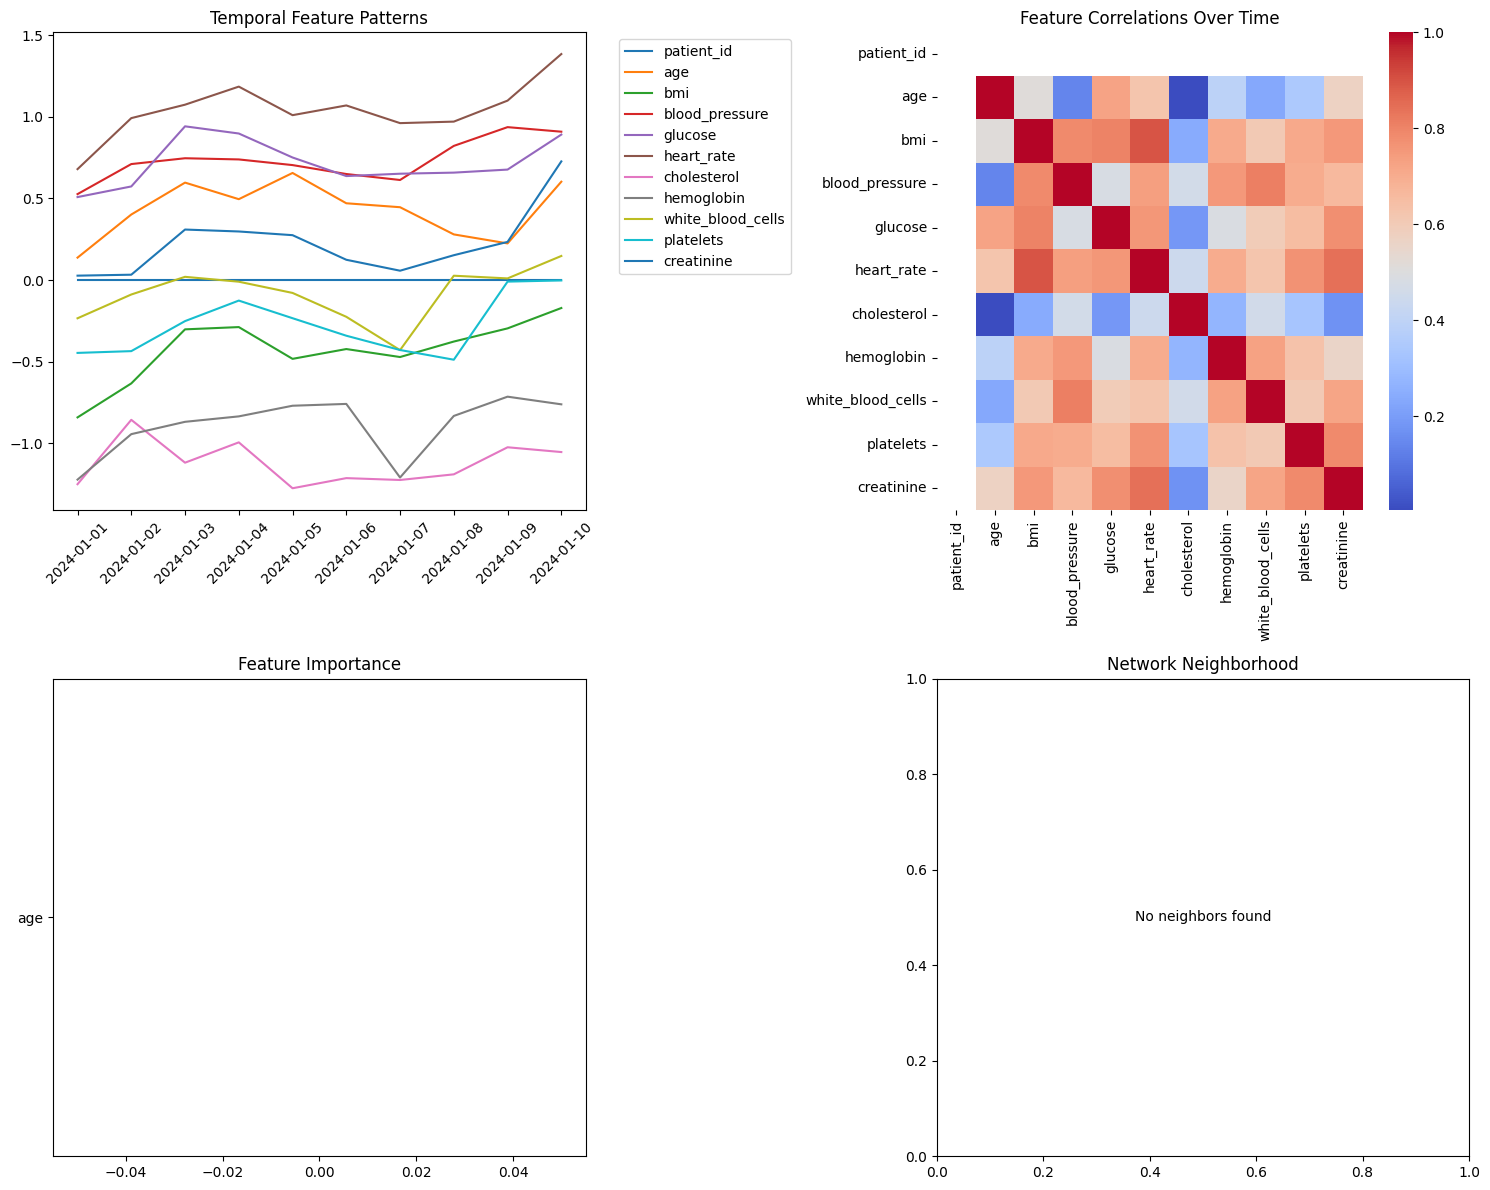

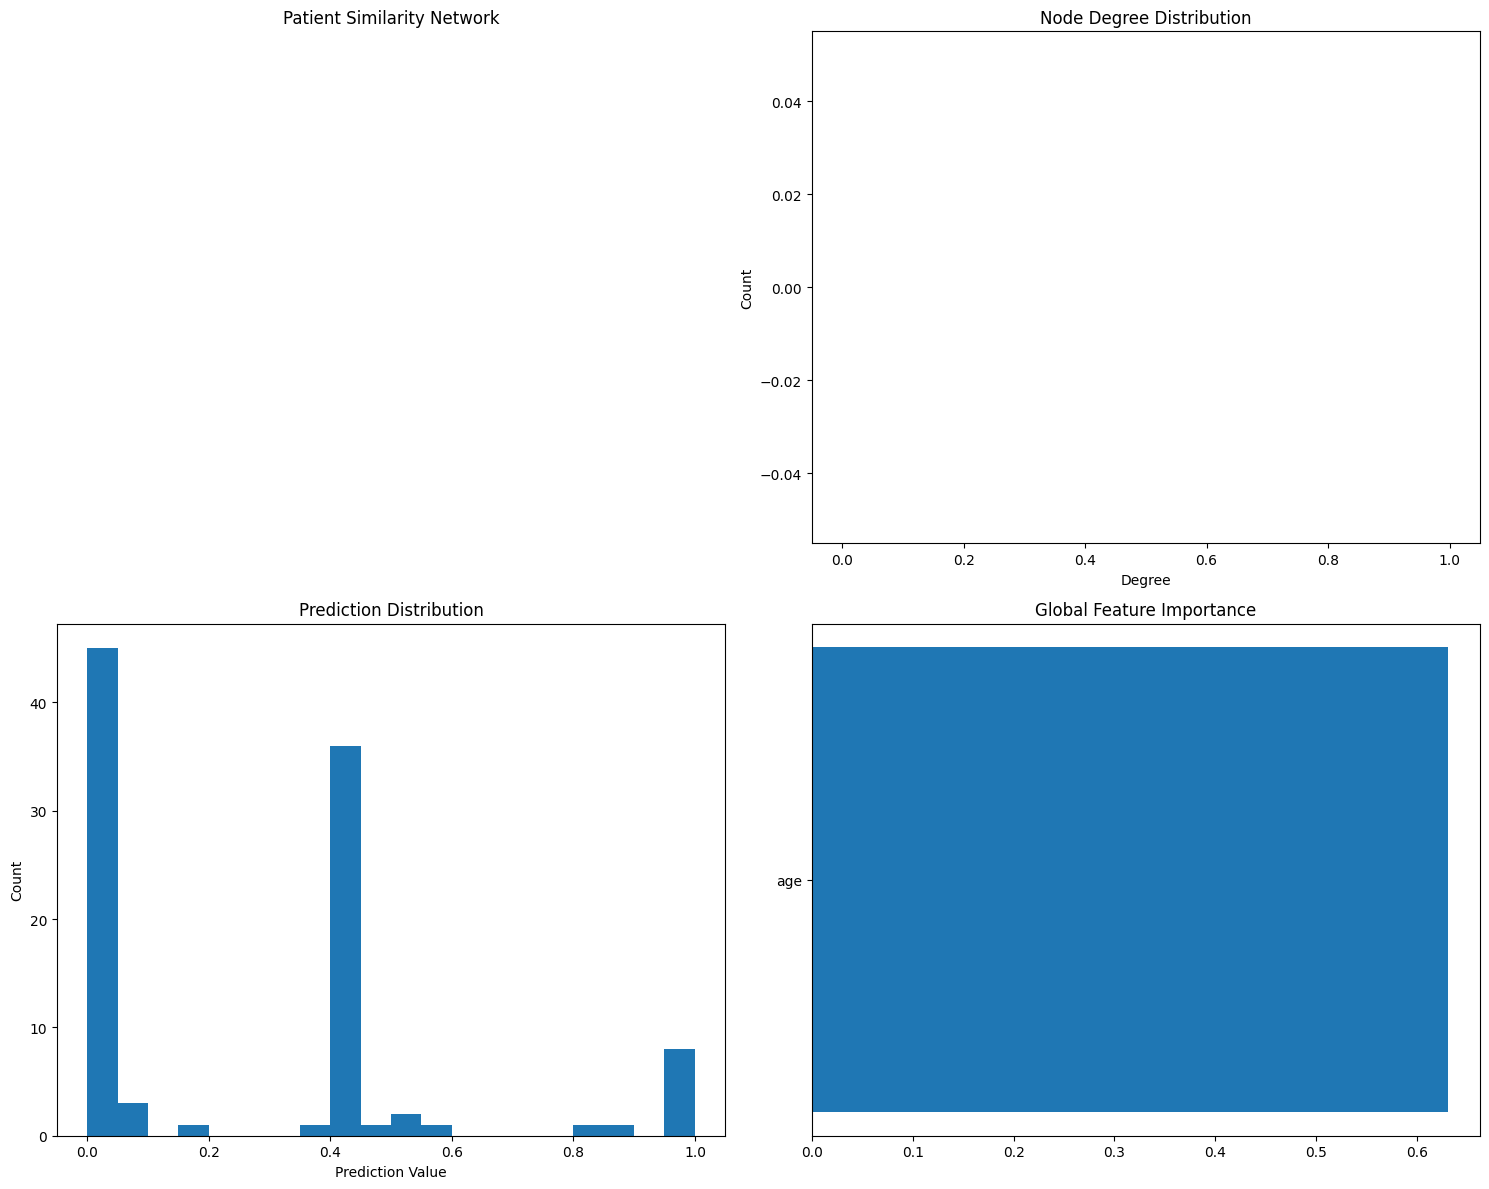

In [11]:
if __name__ == "__main__":
    model, interpreter, temporal_df = main()